In [1]:
import boto3
import pandas as pd
import os
from datetime import datetime as dt

In [2]:
# !pip install s3fs matplotlib ipywidgets

In [4]:
os.environ.setdefault('AWS_PROFILE', 'default')

'default'

In [5]:
os.environ.setdefault('AWS_DEFAULT_REGION', 'us-east-1')

'us-east-1'

In [6]:
# ! pip install kaggle

# ! mkdir ~/.kaggle
# ! cp ~/Dev/kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

In [7]:
! ls -ltr ~/.kaggle/

total 8
-rw-------@ 1 sreejith  staff  69 Dec 10 13:56 kaggle.json


In [15]:
!kaggle datasets download twinkle0705/state-wise-power-consumption-in-india
!unzip state-wise-power-consumption-in-india

  0%|                                                | 0.00/123k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 123k/123k [00:00<00:00, 1.91MB/s]
Archive:  state-wise-power-consumption-in-india.zip
  inflating: dataset_tk.csv          
  inflating: long_data_.csv          


In [8]:
# from urllib.request import urlretrieve
# urlretrieve(github_raw_url, 'energy_dataset.csv')

In [9]:
! ls

aws_forecast_energy_timeseries.ipynb
aws_forecast_example.ipynb
backup.txt
dataset_tk.csv
energy_dataset.csv
energy_dataset_set_date_index.csv
energy_dataset_target_series.csv
long_data_.csv
maharashtra_energy_dataset_filled.csv
maharashtra_energy_dataset_target_series.csv
state-wise-power-consumption-in-india.zip
venv


# Prepare Training Data

In [10]:
data_df = pd.read_csv('energy_dataset.csv')

In [11]:
data_df.head()

,utc_timestamp,cet_cest_timestamp,CY_load_actual_entsoe_transparency,CY_load_forecast_entsoe_transparency,CY_wind_onshore_generation_actual,GB_GBN_load_actual_entsoe_transparency,GB_GBN_load_forecast_entsoe_transparency,GB_GBN_solar_capacity,GB_GBN_solar_generation_actual,GB_GBN_solar_profile,...,GB_UKM_wind_offshore_generation_actual,GB_UKM_wind_onshore_capacity,GB_UKM_wind_onshore_generation_actual,IE_load_actual_entsoe_transparency,IE_load_forecast_entsoe_transparency,IE_wind_onshore_generation_actual,IE_sem_load_actual_entsoe_transparency,IE_sem_load_forecast_entsoe_transparency,IE_sem_price_day_ahead,IE_sem_wind_onshore_generation_actual
0,2014-12-31T23:00:00Z,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-31T23:30:00Z,2015-01-01T00:30:00+0100,NaN,NaN,NaN,NaN,NaN,2664.0,NaN,NaN,...,NaN,8173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01T00:00:00Z,2015-01-01T01:00:00+0100,NaN,NaN,NaN,NaN,NaN,2669.0,NaN,NaN,...,NaN,8174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01T00:30:00Z,2015-01-01T01:30:00+0100,NaN,NaN,NaN,26758.0,32057.0,2669.0,NaN,NaN,...,NaN,8174.0,385.33,2832.37,3550.0,1335.88,3681.37,NaN,NaN,1721.21
4,2015-01-01T01:00:00Z,2015-01-01T02:00:00+0100,NaN,NaN,NaN,27561.0,32135.0,2669.0,NaN,NaN,...,NaN,8174.0,1050.04,2726.20,3403.0,1289.69,3523.20,NaN,NaN,1675.24


In [12]:
df = data_df[['utc_timestamp','GB_GBN_solar_generation_actual']].dropna().reset_index(drop=True)
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp']).dt.date
df = df.groupby(['utc_timestamp']).sum().reset_index()
df.columns =['date','y']

In [13]:
df.head()

,date,y
0,2015-01-01,756.0
1,2015-01-02,7663.0
2,2015-01-03,2049.0
3,2015-01-04,5423.0
4,2015-01-05,4070.0


In [14]:
# (data_1 == data).value_counts()

In [15]:
df.set_index('date', inplace=True)

In [16]:
# Check for missing dates
date_range = pd.date_range(df.index[0], df.index[-1])
len(date_range) == len(df.index)

True

In [17]:
# Check for missing data
df.isna().value_counts()

y    
False    2100
dtype: int64

In [18]:
df.to_csv('energy_dataset_set_date_index.csv')

In [19]:
!ls

aws_forecast_energy_timeseries.ipynb
aws_forecast_example.ipynb
backup.txt
dataset_tk.csv
energy_dataset.csv
energy_dataset_set_date_index.csv
energy_dataset_target_series.csv
long_data_.csv
maharashtra_energy_dataset_filled.csv
maharashtra_energy_dataset_target_series.csv
state-wise-power-consumption-in-india.zip
venv


In [20]:
!head -n 5 energy_dataset_set_date_index.csv

date,y
2015-01-01,756.0
2015-01-02,7663.0
2015-01-03,2049.0
2015-01-04,5423.0


In [21]:
# AWS Forecast requires an column 'item_id'
df['item_id'] = 'GB'

In [22]:
df.head()

,y,item_id
date,,
2015-01-01,756.0,GB
2015-01-02,7663.0,GB
2015-01-03,2049.0,GB
2015-01-04,5423.0,GB
2015-01-05,4070.0,GB


In [23]:
# Leave last 30 points for evaluating Forecast predictions
FORECAST_LENGTH = 30
train = df.iloc[:-FORECAST_LENGTH]

In [83]:
print(f"Length of dataset: {len(df)} \nLength of training data: {len(train)}")

Length of dataset: 2100 
Length of training data: 2070


In [25]:
# AWS can have a "target time series" and a "related time series"
train_target_series = train  # Here we doesn't have any additional data columns for related series

In [26]:
# Save data to be uploaded to S3
train_target_series.to_csv("energy_dataset_target_series.csv", header=None)

In [27]:
!head -n 5 energy_dataset_target_series.csv

2015-01-01,756.0,GB
2015-01-02,7663.0,GB
2015-01-03,2049.0,GB
2015-01-04,5423.0,GB
2015-01-05,4070.0,GB


# Importing the Data

## Create Dataset Group

In [28]:
bucket_name = 'energy-prediction-aws-forecast'

In [29]:
role_arn = 'arn:aws:iam::312202024311:role/ForecastRoleS3Access'

In [53]:
# Forecast time unit granularity
DATASET_FREQUENCY = 'D'
TIMESTAMP_FORMAT = 'yyyy-MM-dd'

PROJECT = 'daily_energy_forecast'
DATA_VERSION = 1

dataset_group = f'{PROJECT}_dataset_group_{DATA_VERSION}'
print(f"Dataset Group Name = {dataset_group}")

Dataset Group Name = daily_energy_forecast_dataset_group_1


In [38]:
forecast_client = boto3.client('forecast')
forecastquery_client = boto3.client('forecastquery')

In [39]:
forecastquery_client

In [43]:
assert forecast_client.list_predictors()

In [44]:
# create a dataset group
dataset_arns = []
create_dataset_group_response = forecast_client.create_dataset_group(Domain='CUSTOM',
                                                                     DatasetGroupName=dataset_group,
                                                                     DatasetArns=dataset_arns)

In [45]:
# wait until its complete!
dataset_group_arn = create_dataset_group_response['DatasetGroupArn']
describe = forecast_client.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

print(describe['Status'])
print(describe['CreationTime'])
print(describe['LastModificationTime'])

ACTIVE
2022-12-12 01:58:41.886000+00:00
2022-12-12 01:58:41.886000+00:00


## Create Schema

In [46]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
target_schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

In [51]:
# Give our dataset a name
target_dataset_name = f'{PROJECT}_{DATA_VERSION}'
print(f'Dataset name = {target_dataset_name}' )

Dataset name = daily_energy_forecast_1


## Create a Dataset

In [48]:
response = forecast_client.create_dataset(Domain="CUSTOM",
                                          DatasetType='TARGET_TIME_SERIES',
                                          DatasetName=target_dataset_name,
                                          DataFrequency=DATASET_FREQUENCY,
                                          Schema=target_schema)

In [49]:
# Check the response
target_dataset_arn = response['DatasetArn']
describe = forecast_client.describe_dataset(DatasetArn=target_dataset_arn)

print(describe['Status'])
print(describe['CreationTime'])
print(describe['LastModificationTime'])

ACTIVE
2022-12-12 02:00:08.203000+00:00
2022-12-12 02:00:08.203000+00:00


## Update the dataset group with the datasets we created

In [50]:
dataset_arns = []
dataset_arns.append(target_dataset_arn)
forecast_client.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)

{'ResponseMetadata': {'RequestId': '9d97654c-27f3-4d69-9ade-ea6279609fb5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 12 Dec 2022 02:00:25 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '9d97654c-27f3-4d69-9ade-ea6279609fb5'},
  'RetryAttempts': 0}}

## Upload Data to S3

In [52]:
# s3r = boto3.resource('s3')
# s3r.Bucket(bucket_name).Object("energy_dataset_target_series.csv").upload_file("energy_dataset_target_series.csv")

In [36]:
s3_client = boto3.client('s3')
s3_client.upload_file(Filename='energy_dataset_target_series.csv', 
                      Bucket=bucket_name, 
                      Key='energy_dataset_target_series.csv')

In [37]:
s3_objects = s3_client.list_objects(Bucket=bucket_name)

for content in s3_objects['Contents']:
    print(content['Key'])

energy_dataset_target_series.csv


## Create a Target Time Series Dataset Import Job

`Now that Forecast knows how to understand the CSV we are providing, the next step is to import the data from S3 into Amazon Forecast`

In [54]:
# Recall path to your data in S3
key = 'energy_dataset_target_series.csv'
s3_target_data_path = "s3://"+bucket_name+"/"+key
print(f"S3 URI for your data file = {s3_target_data_path}")

S3 URI for your data file = s3://energy-prediction-aws-forecast/energy_dataset_target_series.csv


In [55]:
role_arn

'arn:aws:iam::312202024311:role/ForecastRoleS3Access'

In [58]:
# Launching the import job
target_dataset_import_job_response = \
    forecast_client.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                              DatasetArn=target_dataset_arn,
                                              DataSource= {
                                                 "S3Config" : {
                                                     "Path": s3_target_data_path,
                                                     "RoleArn": role_arn
                                                 } 
                                               },
                                               TimestampFormat=TIMESTAMP_FORMAT)

In [80]:
# Check the response
target_dataset_import_job_arn = target_dataset_import_job_response['DatasetImportJobArn']
describe = forecast_client.describe_dataset_import_job(DatasetImportJobArn=target_dataset_import_job_arn)

# Check the status of dataset (Status changes from CREATE_IN_PROGRESS -> ACTIVE). 
# This process will take 5 to 10 minutes.
print(describe['Status'])
print(describe['CreationTime'])
print(describe['LastModificationTime'])

ACTIVE
2022-12-12 02:19:35.229000+00:00
2022-12-12 02:25:11.491000+00:00


In [77]:
# forecast_client.describe_dataset_import_job(DatasetImportJobArn=target_dataset_import_job_arn)
describe['FieldStatistics']

{'item_id': {'Count': 2070,
  'CountDistinct': 1,
  'CountNull': 0,
  'CountLong': 2070,
  'CountDistinctLong': 1,
  'CountNullLong': 0},
 'target_value': {'Count': 2070,
  'CountDistinct': 2049,
  'CountNull': 0,
  'CountNan': 0,
  'Min': '756.0',
  'Max': '161247.0',
  'Avg': 56612.198541062804,
  'Stddev': 37432.458714454624,
  'CountLong': 2070,
  'CountDistinctLong': 2049,
  'CountNullLong': 0,
  'CountNanLong': 0},
 'timestamp': {'Count': 2070,
  'CountDistinct': 2070,
  'CountNull': 0,
  'Min': '2015-01-01T00:00:00',
  'Max': '2020-08-31T00:00:00',
  'CountLong': 2070,
  'CountDistinctLong': 2070,
  'CountNullLong': 0}}

In [93]:
# # check if we can communicate with Forecast API session
forecast_client.list_predictors()

{'Predictors': [],
 'ResponseMetadata': {'RequestId': 'ac80392f-2d92-4aae-8de3-f9882e32311b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 12 Dec 2022 13:54:25 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '17',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'ac80392f-2d92-4aae-8de3-f9882e32311b'},
  'RetryAttempts': 0}}

# Create a Predictor

Once the datasets are specified with the corresponding schema, AWS Forecast will automatically aggregate, at the specified time granularity, all the relevant pieces of information for each item and generate the desired dataset. 

Next choose an algorithm (forecasting model) and evaluate how it works on this dataset.

[Amazon Forecast Algorithms](https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-choosing-recipes.html)

Amazon Forecast provides several forecasting algorithms including classic forecasting methods such as ETS, ARIMA, Prophet and deep learning approaches such as DeepAR+.

[DeepAR+](https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-recipe-deeparplus.html)

1. Choose PerformAutoML=True if we want to let Amazon Forecast choose an ML algorithm automatically.  
2. If you know which algorithm you want, we can automate the Hyperparameter tuning by choosing PerformHPO=True.
3. Else can specify exactly which algorithm and enter our own hyperparameter values

In [90]:
algorithm = 'Deep_AR_Plus'
algorithm_arn = 'arn:aws:forecast:::algorithm/'+algorithm

In [91]:
predictor_name = 'deep_ar_plus_predictor'

In [94]:
# By default, returns 0.1, 0.5 and 0.9 (ForecastTypes default)

create_predictor_response = \
    forecast_client.create_predictor(PredictorName=predictor_name,
                                     AlgorithmArn=algorithm_arn,
                                     ForecastHorizon=FORECAST_LENGTH,
                                     PerformAutoML=False,
                                     PerformHPO=False,
                                     # ForecastTypes=['0.1', '0.5', '0.9', 'mean'],
                                     InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                                     FeaturizationConfig= {"ForecastFrequency": DATASET_FREQUENCY})

In [95]:
predictor_arn = create_predictor_response['PredictorArn']

In [103]:
describe = forecast_client.describe_predictor(PredictorArn=predictor_arn)

# Check the status of predictor (Status changes from CREATE_IN_PROGRESS -> ACTIVE). 
# Depending on data size, model selection and choice of hyper parameters tuning，it can take several hours to be ACTIVE.
print(describe['Status'])
print(describe['CreationTime'])
print(describe['LastModificationTime'])

ACTIVE
2022-12-12 13:57:04.323000+00:00
2022-12-12 14:25:46.894000+00:00


## Get Predictor Accuracy Metrics

In [108]:
forecast_client.get_accuracy_metrics(PredictorArn=predictor_arn)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 30282.552459720067,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.12988366379599667},
       {'Quantile': 0.5, 'LossValue': 0.3086746299300526},
       {'Quantile': 0.1, 'LossValue': 0.18093173243557065}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 0.31371337942554056,
        'RMSE': 30282.552459720067,
        'MASE': 1.1058337622204264,
        'MAPE': 0.4228575183310188}],
      'AverageWeightedQuantileLoss': 0.20649667538720662}},
    {'TestWindowStart': datetime.datetime(2020, 8, 2, 1, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2020, 9, 1, 1, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 30282.552459720067,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.129883663795

# Generate Forecast

In [111]:
forecast_name = f'{PROJECT}_{DATA_VERSION}_{algorithm}'
print(f'Forecast name: {forecast_name}')

Forecast name: daily_energy_forecast_1_Deep_AR_Plus


In [113]:
create_forecast_response=forecast_client.create_forecast(ForecastName=forecast_name,
                                                         PredictorArn=predictor_arn)

forecast_arn = create_forecast_response['ForecastArn']

In [122]:
# Check the status of forecast process (Status changes from CREATE_IN_PROGRESS -> ACTIVE). 
# Depending on data size, model selection and choice of hyper parameters tuning，it can take several hours to be ACTIVE.

describe = forecast_client.describe_forecast(ForecastArn=forecast_arn)
print(describe['Status'])
print(describe['CreationTime'])
print(describe['LastModificationTime'])

ACTIVE
2022-12-12 15:01:42.123000+00:00
2022-12-12 15:26:34.074000+00:00


## Check Forecast results

In [123]:
forecast_response = forecastquery_client.query_forecast(ForecastArn=forecast_arn,
                                                        Filters={'item_id': 'GB'})

In [124]:
forecast_response

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2020-09-01T00:00:00',
     'Value': 49113.328125},
    {'Timestamp': '2020-09-02T00:00:00', 'Value': 54249.828125},
    {'Timestamp': '2020-09-03T00:00:00', 'Value': 49990.3515625},
    {'Timestamp': '2020-09-04T00:00:00', 'Value': 49582.3203125},
    {'Timestamp': '2020-09-05T00:00:00', 'Value': 36344.0703125},
    {'Timestamp': '2020-09-06T00:00:00', 'Value': 41522.2421875},
    {'Timestamp': '2020-09-07T00:00:00', 'Value': 41185.6484375},
    {'Timestamp': '2020-09-08T00:00:00', 'Value': 44357.2109375},
    {'Timestamp': '2020-09-09T00:00:00', 'Value': 44996.7265625},
    {'Timestamp': '2020-09-10T00:00:00', 'Value': 45465.0703125},
    {'Timestamp': '2020-09-11T00:00:00', 'Value': 43030.2109375},
    {'Timestamp': '2020-09-12T00:00:00', 'Value': 49506.328125},
    {'Timestamp': '2020-09-13T00:00:00', 'Value': 53441.9375},
    {'Timestamp': '2020-09-14T00:00:00', 'Value': 50880.8984375},
    {'Timestamp': '2020-09-15T00:00:00', 'V

## Plot our Predictions

In [125]:
# Generate DF 
prediction_df_p10 = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p10'])
prediction_df_p10.head()

,Timestamp,Value
0,2020-09-01T00:00:00,49113.328125
1,2020-09-02T00:00:00,54249.828125
2,2020-09-03T00:00:00,49990.351562
3,2020-09-04T00:00:00,49582.320312
4,2020-09-05T00:00:00,36344.070312


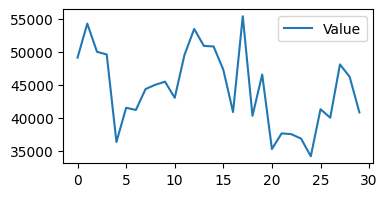

In [135]:
# Plot
prediction_df_p10.plot(figsize=(4,2));

In [129]:
prediction_df_p50 = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p50'])
prediction_df_p90 = pd.DataFrame.from_dict(forecast_response['Forecast']['Predictions']['p90'])

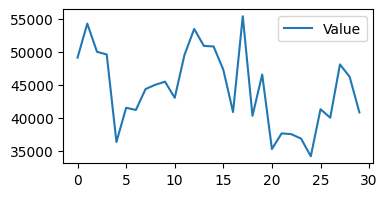

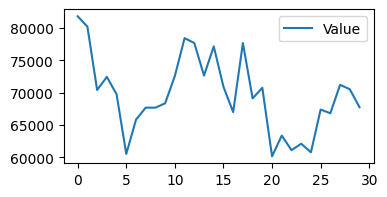

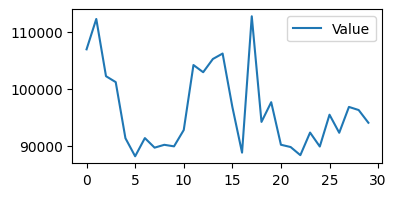

In [137]:
prediction_df_p10.plot(figsize=(4,2))
prediction_df_p50.plot(figsize=(4,2))
prediction_df_p90.plot(figsize=(4,2));

In [138]:
def parse_aws_forecast(d10, d50, d90):
    ts = pd.Timestamp(d10['Timestamp'])
    val1 = d10['Value']
    val2 = d50['Value']
    val3 = d90['Value']
    return ts, val1, val2, val3

In [139]:
p10 = forecast_response['Forecast']['Predictions']['p10']
p50 = forecast_response['Forecast']['Predictions']['p50']
p90 = forecast_response['Forecast']['Predictions']['p90']

In [159]:
parsed = [parse_aws_forecast(d1, d2, d3) for d1, d2, d3 in zip(p10, p50, p90)]

forecast_df = pd.DataFrame(parsed, columns=['timestamp', 'p10', 'p50', 'p90'])
forecast_df.set_index('timestamp', inplace=True)
forecast_df.head()

,p10,p50,p90
timestamp,,,
2020-09-01,49113.328125,81825.156250,106917.296875
2020-09-02,54249.828125,80218.250000,112242.031250
2020-09-03,49990.351562,70420.703125,102206.718750
2020-09-04,49582.320312,72441.125000,101168.234375
2020-09-05,36344.070312,69765.257812,91330.578125


In [160]:
true_df = df[['y']].copy()
true_df.columns = ['actual']

In [155]:
full_df = true_df.join(forecast_df, how='outer')
full_df.tail()

,actual,p10,p50,p90
2020-09-26,72645.0,41302.906250,67393.992188,95452.523438
2020-09-27,74526.0,40018.031250,66818.101562,92283.562500
2020-09-28,47717.0,48077.007812,71217.921875,96816.273438
2020-09-29,61357.0,46202.429688,70534.468750,96270.554688
2020-09-30,19071.0,40814.257812,67762.179688,94040.117188


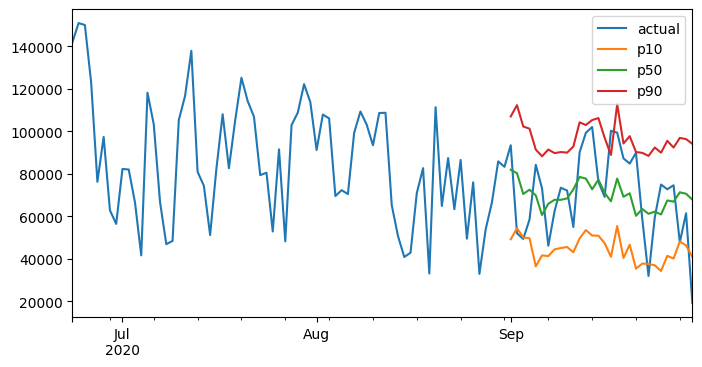

In [158]:
# full_df[['true', 'p10', 'p50', 'p90']].plot(figsize=(20, 10));
full_df.iloc[-100:][['actual', 'p10', 'p50', 'p90']].plot(figsize=(8, 4));